In [1]:
# MNIST el yazımı rakamlar scikit lear içinde
from sklearn.datasets import fetch_mldata

In [2]:
mnist = fetch_mldata('MNIST original')
# veriseti $HOME/scikit_learn_data

In [3]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [4]:
# veri setini bağımlı ve bağımsız değişkenlere bölmek
X, y = mnist['data'], mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
# veri setinde 784 özelliği olan (28*28 px) 70 bin kayıt var. Her bir özellik 0 (beyaz) ile 255 (siyah) arası değer alıyor. 
# Bunlardan bir tanesini görmek istersek 28*28 boyutunda şekillendirip motplotlib kütüphanesinin imshow() fonksiyonu ile görüntüleyebiliriz.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [8]:
bir_rakam = X[1000].reshape(28,28)

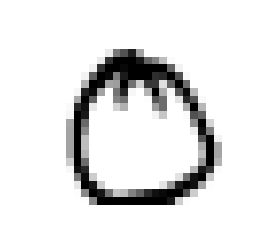

In [9]:
plt.imshow(bir_rakam, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [10]:
# sıfıra benziyor. Bakalım hedef değişken kaç imiş. 
y[1000]

0.0

In [11]:
# Sıfırmış. Doğru bilmişiz :)

In [12]:
# veri setini eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000],y[60000:]

In [13]:
# Kartların bulunduğu desteyi karıştıralım. Shuffle edelim.
import numpy as np

In [14]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [15]:
# Olayı binary classification yapmak için sadece 5 rakamına odaklanalım. Etiketi beş olanlar True diğerleri False olacak.
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [16]:
# Scikit Learn kütüphanesinden StochasticGradient Descent sınıflandırıcısını seçelim.
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)

In [17]:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [18]:
# sınıflandırıcıyı (sgd_clf) eğittik. Şimdi sıra tahminde
sgd_clf.predict([X[36000]])

array([ True], dtype=bool)

In [19]:
sgd_clf.predict([X[1001]])

array([False], dtype=bool)

In [20]:
# performans ölçümü
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    

0.9518
0.9468
0.963


In [21]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.9518,  0.9468,  0.963 ])

In [22]:
# Oranın yüksekliği şaşırtmasın. Sadece beiş rakamına baktık.
# Baz doğruluğu (accuracy) hesaplayalım
from sklearn.base import BaseEstimator

In [23]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [24]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9108 ,  0.9101 ,  0.90805])

In [25]:
# Evet görgüğümüz gibi baz model başarısı 90 civarı. Yani biz karşımıza gelen imaj karşısında bu 5 veya değil diye kafadan sıksaydık
# % 90 başarı sağlayacaktık.Çünkü on tane rakam arasında 5 popülasyonun % 10'unu oluşturuyor.
# Hata matrisi

In [26]:
from sklearn.model_selection import cross_val_predict

In [27]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
confusion_matrix(y_train_5, y_train_pred)

array([[53824,   755],
       [ 2013,  3408]])

In [30]:
# Matristeki her bir satır gerçek sınıfları, her bir sütun ise tahminleri belirtir. sol üst köşedeki rakam beş olmayanların doğru
# sınıflandırılma sayısını belirtir. Aynı satırdaki diğer rakam (sağ üst köşe) ise yanlış sınıflandırılanları
#                yanlış       doğru
#beş olmayanlar  50970(TN)    3609(FP)
#beş olanlar       539(FN)    4882(TP)

# Eğer sınıflandırıcı mükemmel olsaydı matris şöyle olurdu
#                yanlış       doğru
#beş olmayanlar  54579(TN)    0(FP)
#beş olanlar       0(FN)    5421(TP)


In [31]:
# Hata matrisinden bir çok metrik elde edilebilir. Bunlardan birisi Precision'dır.
# precision = TP / (TP+FP)
# yukarıdaki formülde FP'nin 0 olması halinde precision en yüksek değeri (1) alabilecektir. 

In [32]:
4882 / (4882 + 3609)

0.574961724178542

In [33]:
# Precision genelde başka bir metric olan recall/sensitivity/TPR ile birlikte kullanılır. 
# recall = TP / (TP+FN) 
# doğru tahminlerin sınıfın toplam mevcuduna oranıdır.
# Toparlarsak precision da doğru tahminler toplam doğru tahminlere oranlanırken, recall da doğru tahminler sınıfın mevcuduna oranlanır.


In [34]:
4882 / (4882 + 539)

0.900571850212138

In [35]:
# Yukarıda formüllerini verip açıkladığımız metrikleri sağolsun scikit-learn hesaplayıp bize veriyor
from sklearn.metrics import precision_score, recall_score

In [36]:
precision_score(y_train_5, y_train_pred)

0.81864040355512846

In [37]:
recall_score(y_train_5, y_train_pred)

0.62866629773104599

In [38]:
# F1 ise precision ve recall metriklerinin birleşmesinden oluşur. F1 bu ikisinin harmonik ortalamasıdır. Aritmetik ortalama 
# her gözlemin ağırlığını eşit oranda alırken harmonik ortalama zayıfları kayırır. 
# F1 = 2 / [(1/precision) + (1/recall)] = TP / [TP + ((FN+FP)/2)]

In [39]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.71118530884808007

In [40]:
# F1 değeri recall ve precision değerleri birbirine yakın olan sınıflandırıcıları ödüllendirir. 
# Ancak bazen iki değerden birini yüksek tutmak gerekebilir. Çocukların görmemesi gereken bir videoyu sınıflandırmak gerekirse
# precision yüksek recall düşük tutulmalı. 

# Precision/Recall Tradeoff

In [41]:
# Stochastic Gradient Descend Sınıflandırıcı her örnek için karar fonksiyonuna göre bir değer hesaplar. Belirlenen eşiğe göre 
y_scores = sgd_clf.decision_function([X[36000]])

In [42]:
y_scores

array([ 38391.0290165])

In [43]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [44]:
y_some_digit_pred

array([ True], dtype=bool)

In [45]:
# Yukarıda eşiği 0 aldığımız için sonuçlar sadece precision verecektir.
# treshold u biraz arttıralım
threshold = 20000
y_some_digit_pred = (y_scores > threshold)

In [46]:
y_some_digit_pred

array([ True], dtype=bool)

In [47]:
# Hangi eşik değerinin kullanılacağına nasıl karar verilecek?
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [48]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

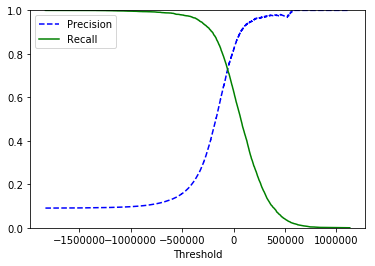

In [49]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
    

In [50]:
# % 90 precision istiyoruz
y_train_pred_90 = (y_scores > 200000)
precision_score(y_train_5, y_train_pred_90)

0.9569019362898189

In [51]:
recall_score(y_train_5, y_train_pred_90)

0.28260468548238332

# ROC Curve

ROC precision/recall eğrisine benzer. Burada y eksenini TPR x eksenini FPR oluşturur. TPR Doğru tahmin edilen pozitiflerin, pozitif sınıfa oranıdır. FPR ise yanlış tahmin edilen negatiflerin, negatif sınıfa oranıdır. Bu sebeple ROC curve recal (sensivity) ile 1 - specifity arasındaki ilişkiyi gösteren grafiktir.

In [52]:
from sklearn.metrics import roc_curve

In [53]:
fpr, tpr, tresholds = roc_curve(y_train_5, y_scores)

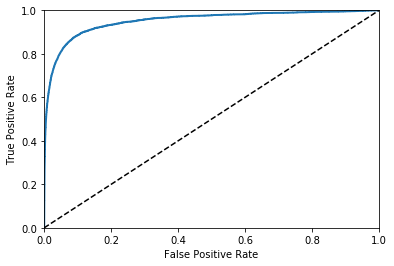

In [54]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

Buradada bir denge var. Yüksek TPR demek daha fazla FPR demek. Orijinden sağ üste doğru uzanan kesikli çizgi rastsal baz 
sınıflandırıcıyı temsil eder. Dolayısıyla ROC eğrisi ne kadar bu çizgiden uzak olursa sınıflandırıcı o kadar başarılıdır.
Sınıflandırıcıların performanslarını karşılaştırmanın bir yolu da Ander Area of Curve (AUC) dir. Mükemmel bir sınıflandırıcı için AUC 1'dir. Scikit learn hesaplıyor

In [55]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.95130586861496091

Peki nezam PR ne zaman ROC kullanacağız? Kural olarak pozitif sınıf seyrek ise veya yanlış pozitifleri yanlış negatiflerden daha çok önemsiyorsan PR, aksi halde ROC.

# SGDClassifier ile RandomForest Karşılaştırma

In [56]:
# RandomForestClassifier decision_function() yerine predict_proba() kullanır. Her örnek için 5 olma olasılığını hesaplar.
from sklearn.ensemble import RandomForestClassifier

In [57]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [58]:
# Ancak grafik çizmek için olasılık değerlerine değil rakamlara ihtiyaç var. Basit bir çözüm ise pozitif sınıfların olasılıklarını
# skor olarak kullanmak.

In [59]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, tresholds_forest = roc_curve(y_train_5, y_scores_forest)

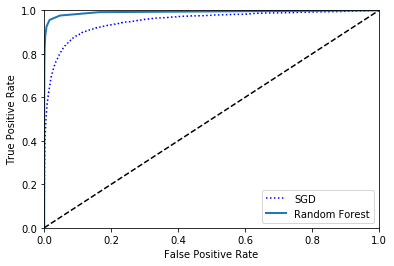

In [60]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [61]:
# Gördüğümüz gibi Random Forest'in eğrisi SGD'den çok daha iyi. Bunun bir sonucu olarak ROC AUC değeri de daha yüksek olacaktır.

In [62]:
roc_auc_score(y_train_5, y_scores_forest)

0.99205988409362145

In [63]:
# Precision ve recall hesaplayalım.y_scores_forest olasılıkları hesapladığı için onu bir eşik değerden geçirelim. Bu eşik değeri
# 0.5 yaptım. Bu değerden büyük olasılığa sahip olanlar True, küçükler False dönecektir (y_scores_forest > 0.5)

In [64]:
precision_score(y_train_5, (y_scores_forest > 0.5))

0.98349108518600048

In [65]:
recall_score(y_train_5, (y_scores_forest > 0.5))

0.82420217672016238

# Multiclass Classification 

RandomForest ve Naive Bayes doğrudan multiclass hesaplayabilir. SVM ve lineer sınıflandırıcılar ise binary sınıflandırıcıdır.
Ancak 10 rakam için 10 farklı sınıflandırıcı oluşturup sonuçlar birleştirilerek de binary sınıflandırıcılar kullanılabilir. one-versus-all OvA stratejisi. Başka bir strateji ise rakamları çiftler halinde sınıflandırmaktır bu da one-versus-one (OvO). OvO'da 10*(10-1)/2 tane sınıflandırıcı oluşturmak gerekir. Dejavantajı bu ancak eğitim için iki sınıfa ait örnekler kullanılır. Veri hacmine duyarlı sınıflandırıcılar için (örn. SVM) uygun olabilir. Ancak 45 tane sınıflandırıcı nesne yaratmak eğitmek test etmek gerekecektir. 

Scikit-learn multiclass bir veri üzerinde binary sınıflandırıcı denediğinizde bunu algılar ve otomatik olarak OvA stratejisini uygular.(SVM hariç)

In [66]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([X[36000]])

array([ 5.])

İşte bu kadar kolay. Aslında scikit-learn 10 tane binary sınıflandırıcı kullandı ve imaj için bir karar verdi (burada beş).
Aslında burada decision_function() metodunu kullanabiliriz. Bu metod bize 10 sınıfa ait olasılıkları verecektir. En yüksek olan
skor kendi indeksini tahmin etmiş olur. Örneğin 10 elemanlı bir dizide en yüksek skor beşinci indekste ise örnek beş olarak tahmin edilir.

In [67]:
some_digit_scores = sgd_clf.decision_function([X[36000]])
some_digit_scores

array([[-125659.37059527, -462864.93651744, -354977.53907918,
        -107930.03279544, -486627.06892961,   38391.0290165 ,
        -789465.45621307, -297442.05787507, -651930.93071987,
        -618933.66379623]])

In [68]:
# decision_function() tarafından üretilen array içinde en yüksek değerin indeksini öğrenelim
np.argmax(some_digit_scores)

5

In [69]:
# SGD sınıflandırıcının classes_ özelliğine bakalım
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [70]:
# 
sgd_clf.classes_[np.argmax(some_digit_scores)]

5.0

In [71]:
# Eğer Scikit-Learn OvO veya OvA kullansın istiyorsak bunu sınıflandırıcı seçerek belirtebiliriz. OneVsOneClassifier
# OneVsRestClassifier

In [72]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([X[36000]])

array([ 5.])

In [73]:
# OvO'da 10*(10-1)/2 tane sınıflandırıcı çalıştırmak gerek demiştik. Evet 45 tane estimator oluşturulmuş.
len(ovo_clf.estimators_)

45

In [74]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([X[36000]])

array([ 5.])

In [75]:
# Bu sefer scikit learn OvO veya OvA kullanmadı. çünkü random forest kendisi multiclass sınıflandırma yapabilir.
# predic_proba() fonksiyonu ile her sınıfa ait bu olasılıkları görebiliriz.

In [76]:
forest_clf.predict_proba([X[36000]])

array([[ 0. ,  0. ,  0. ,  0.1,  0. ,  0.9,  0. ,  0. ,  0. ,  0. ]])

In [77]:
# Yukarıdaki array içinde görüyoruz ki 5. indeks 0.9 değerini almış. Bu şu demek oluyor. Sınıflandırıcı 5. indekse (5 olma ihtimaline)
# % 90 olasılık veriyor. 

In [78]:
# SGDClassifier accuracy değerini cross validation cross_val() fonksiyonu ile hesaplayalım.

In [79]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.82108578,  0.86619331,  0.83587538])

Beş rakamı toplam ana kütlenin yaklaşık %10'unu oluşturuyor. Şayet rastgele bir sınıflandırma yapılsaydı accuracy %10
civarında olurdu. Biz ise yukarıda %84'leri yakaladık. Ancak bunu daha da yukarı çekmek mümkün. Bunun bir yöntemi de
nitelikleri StandartScaler ile standardize etmektir.

In [80]:
from sklearn.preprocessing import StandardScaler

In [81]:
scaler = StandardScaler()

In [82]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [83]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.90696861,  0.91129556,  0.91038656])

In [84]:
# Evet beklediğimiz gibi doğruluk değeri yaklaşık 6 puan arttı.

# Error Analysis

10 sınıflı bir hata matrisi çizmek

In [85]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5731,    3,   26,   11,   12,   50,   38,   10,   39,    3],
       [   2, 6463,   43,   31,    6,   43,    8,   11,  119,   16],
       [  53,   43, 5352,  103,   81,   25,   80,   54,  152,   15],
       [  49,   39,  136, 5329,    2,  256,   37,   54,  123,  106],
       [  20,   24,   36,    8, 5388,    9,   52,   24,   80,  201],
       [  73,   46,   33,  177,   75, 4624,  101,   25,  166,  101],
       [  33,   24,   45,    2,   48,   93, 5622,    8,   43,    0],
       [  24,   13,   70,   30,   52,   12,    6, 5809,   16,  233],
       [  52,  154,   77,  169,   12,  168,   58,   29, 4986,  146],
       [  45,   27,   29,   87,  165,   42,    1,  212,   72, 5269]])

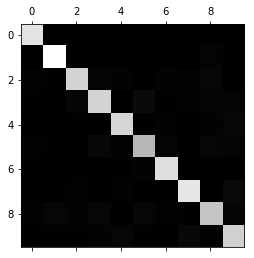

In [86]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [88]:
# Hataları çizmeye odaklanalım. Doğru tahmin edilen sınıfları sınıf sayısına oranlayalım.
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

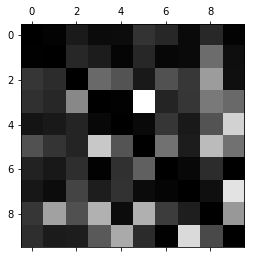

In [90]:
# Köşegeni sıfırla dolduralım ki geriye sadece hatalar kalsın. 
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

Hata matrisini analiz etmek size sınıflandırıcınızı modifiye etmek için güzel fikirler verebilir. 

NameError: name 'plot_digits' is not defined

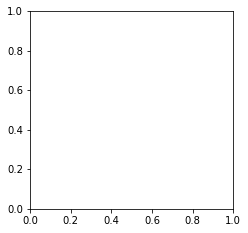

In [91]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_aa = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_aa = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_ab[:25], images_per_row=5)
plt.show()

# Multilabel Classification

In [92]:
from sklearn.neighbors import KNeighborsClassifier

In [93]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [94]:
knn_clf.predict([X[36000]])

array([[False,  True]], dtype=bool)

In [95]:
# Yukarıdaki sonuçta biz 5'i verdik ve tahmin olarak False ve True döndü. 7'den büyük olmadığı için False doğru sonuç,
# tek numara doğru sonuç True.

In [96]:
# Multilabel classifier modeli değerlendirmesi için kullanılan metriklerden birisi de F1'dir. 

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

In [ ]:
# Yukarıda ağırlıklandırma yapılmadı. Baskın sınıfa daha fazla ağırlık verilebilir. Bunun için yukarıdaki average="weighted"
# yazmak yeterlidir.

# Multioutput Classification